**Final Project**

**Author:** Michael Buffington

**Dataset**: https://www.kaggle.com/datasets/mchirico/montcoalert?resource=download

**Addresses Source**: https://experience.arcgis.com/experience/028de5f59b014757bda5cc2444d1f0c9

**Station Locations**: https://webapp02.montcopa.org/mycommunity/poi/MapMontcoEMSSquads_cp.htm

In [13]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import re 
import csv
from scipy import stats

CALLS_FILEPATH = "./911.csv"
STATIONS_FILEPATH = "./stationlocations.csv"

df = pd.read_csv(CALLS_FILEPATH)


#Keep only EMS calls
df = df[df["title"].str.contains("EMS")==True]

#Add station ID Column
exp = re.compile(r'(?<=Station )(.*?)(?=;)')
stations = []    
for description in df['desc']:
    m = exp.search(description)
    if m == None: 
        stations.append('-1')
    else:
        stations.append(str(m.group(0)))        
df['stationID'] = stations

#add station lat longs
stations = {}
with open(STATIONS_FILEPATH) as csvfile:
    reader = csv.reader(csvfile)
    i = 1
    for row in reader:
        stations[row[0]]= [float(row[1]),float(row[2]),i]
        i += 1

df['station-lat'] = [stations[ID][0] if ID in stations else -1 for ID in df['stationID']]
df['station-lng'] = [stations[ID][1] if ID in stations else -1 for ID in df['stationID']]

df = df[df['station-lat'] != -1]
df = df[df['station-lng'] != -1]

#convert timestamp into better format?  DROPPING - it's kinda pointless
#df['timeStamp'] = pd.to_datetime(df['timeStamp'], format='%Y-%m-%d %H:%M:%S')
#df['timeStamp'] = [dt.value // (10**9) for dt in df['timeStamp']]

#add call type
    #split Title into "EMS: " and "..." and keep the second half
df['title'] = df['title'].str[5:]
    
#label encode categorial variables: stationID, title, twp
df['stationID'] = df['stationID'].astype('category')
df['stationID'] = df['stationID'].cat.codes

df['title'] = df['title'].astype('category')
df['title'] = df['title'].cat.codes

df['twp'] = df['twp'].astype('category')
df['twp'] = df['twp'].cat.codes

#drop desc, zip, title, addr, e, timeStamp
df = df.drop(['desc', 'zip', 'addr', 'e', 'timeStamp'], axis=1)

#eliminate outliers
    #there are some lat-lng coordinates that are incorrect and fall outside of Mountgomery County
df = df[(np.abs(stats.zscore(df['lat'])) < 3)]
df = df[(np.abs(stats.zscore(df['lng'])) < 3)]

#get smaller sample size
n=2000
df_subset = df.sample(n)

#drop low response staions THIS NEEDS TO HAPPEN AFTER GETTING A SUBSET OF THE DATA
responsecount = {}
for i in df_subset['stationID']:
    if i in responsecount:
        responsecount[i] = responsecount[i]+1
    else:
        responsecount[i] = 1

responsecount = [(k,v) for k, v in responsecount.items()]
responsecount.sort(key= lambda x: x[0])
stations_to_drop = [x[0] for x in responsecount if (x[1] < 10)]

df_subset = df_subset[~df_subset['stationID'].isin(stations_to_drop)]

In [2]:
df_subset.describe()


,lat,lng,title,twp,stationID,station-lat,station-lng
count,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000,1993.000000
mean,40.160131,-75.312535,42.468138,32.528349,14.523833,40.160191,-75.311711
std,0.081418,0.147652,22.676928,19.259909,10.070861,0.080361,0.148468
min,39.958421,-75.691036,0.000000,0.000000,0.000000,40.007756,-75.637452
25%,40.107419,-75.388625,22.000000,18.000000,5.000000,40.112023,-75.375695
50%,40.143326,-75.310874,41.000000,31.000000,13.000000,40.147633,-75.298645
75%,40.228562,-75.207651,61.000000,50.000000,23.000000,40.236258,-75.209882
max,40.429782,-75.018326,77.000000,66.000000,32.000000,40.392015,-75.049783


In [34]:
df_subset.head()

,lat,lng,title,twp,stationID,station-lat,station-lng
620256,40.089360,-75.274142,72,64,7,40.095014,-75.259506
135574,40.250116,-75.653928,31,40,13,40.243632,-75.637452
214134,40.262773,-75.226571,17,31,20,40.236258,-75.224957
599446,40.154698,-75.139243,59,52,28,40.147633,-75.109802
648753,40.320703,-75.323108,17,49,17,40.311976,-75.335126


In [3]:
D = df_subset.to_numpy()


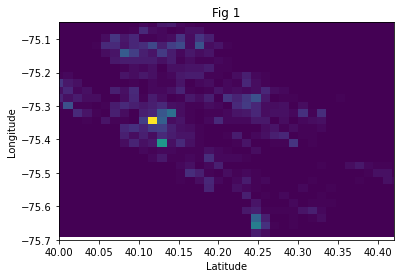

In [17]:
fig, ax = plt.subplots()

ax.hist2d(D[:,0], D[:,1], bins=[40,30])
ax.set(xlim=(40,40.42), ylim=(-75.7,-75.05))
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Fig 1")
plt.show()

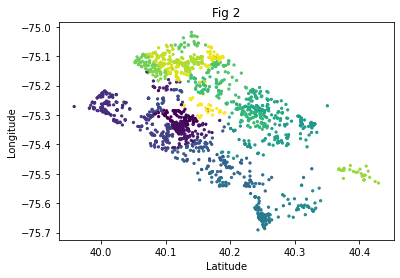

In [18]:
plt.scatter(D[:,0], D[:,1], c=D[:,4], s=5)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Fig 2")
plt.show()

In [6]:
def pnorm(xlat, xlng, ylat, ylng, p):
    xdif = abs(xlat - ylat) ** p
    ydif = abs(xlng - ylng) ** p 
    norm = np.power((xdif+ydif), (1/p))
    return norm

#calculate various p_norms for each call


p_values = [.5,1,2]

np_response_dists = np.ndarray((D.shape[0], len(p_values)+1))


for i, row in enumerate(D):
    distances = [pnorm(row[0], row[1], row[5], row[6], p) for p in p_values]
    distances.append(row[4])
    np_response_dists[i] = distances



In [7]:
#create new array of response stations and their mean distances for responces for each p_value

station_ids = list(set(D[:,4])) #list of station ids. 

station_avg_distances = np.ndarray((len(station_ids), len(p_values)))
station_std_distances = np.ndarray((len(station_ids), len(p_values)))
clusters_truth = [[] for i in station_ids]

for i, station in enumerate(station_ids):
    arr = np_response_dists[np.where(station == np_response_dists[:,-1])]
    clusters_truth[i] = np.where(D[:,4]==i)[0].tolist()
    station_avg_distances[i] = np.mean(arr[:,:-1], axis=0)
    station_std_distances[i] = np.std(arr[:,:-1], axis=0)

print(station_avg_distances.round(3))
#print(station_std_distances.round(3))

[[0.053 0.029 0.022]
 [0.027 0.014 0.011]
 [0.073 0.04  0.032]
 [0.072 0.038 0.03 ]
 [0.065 0.037 0.03 ]
 [0.052 0.028 0.021]
 [0.054 0.031 0.025]
 [0.061 0.032 0.025]
 [0.054 0.029 0.022]
 [0.057 0.03  0.024]
 [0.065 0.035 0.027]
 [0.042 0.024 0.019]
 [0.058 0.032 0.025]
 [0.051 0.029 0.024]
 [0.066 0.036 0.028]
 [0.093 0.05  0.039]
 [0.043 0.024 0.02 ]
 [0.062 0.034 0.026]
 [0.056 0.03  0.024]
 [0.042 0.023 0.018]
 [0.065 0.035 0.027]
 [0.071 0.037 0.028]
 [0.06  0.033 0.026]
 [0.047 0.025 0.019]
 [0.048 0.026 0.02 ]
 [0.078 0.044 0.036]
 [0.057 0.03  0.022]
 [0.053 0.028 0.022]
 [0.061 0.033 0.026]
 [0.046 0.025 0.02 ]
 [0.037 0.021 0.017]
 [0.055 0.03  0.024]]


In [8]:
station_locations = np.ndarray((len(station_ids), 3))


for i, stationid in enumerate(station_ids):
    index = np.where(D[:,4]==stationid)[0][0]
    station_locations[i] = [stationid, D[index, 5], D[index, 6]]

print(station_locations)


[[  0.         40.1281814 -75.298645 ]
 [  1.         40.115244  -75.34605  ]
 [  2.         40.1564214 -75.3756953]
 [  3.         40.085569  -75.188896 ]
 [  4.         40.007756  -75.285435 ]
 [  5.         40.0742139 -75.2973098]
 [  6.         40.096696  -75.36554  ]
 [  7.         40.095014  -75.259506 ]
 [  8.         40.15083   -75.399425 ]
 [  9.         40.1263997 -75.431543 ]
 [ 10.         40.189901  -75.456345 ]
 [ 11.         40.2309321 -75.5216765]
 [ 12.         40.1795437 -75.5363835]
 [ 13.         40.2436325 -75.6374521]
 [ 15.         40.3168182 -75.6194839]
 [ 16.         40.2237782 -75.4095379]
 [ 17.         40.311976  -75.335126 ]
 [ 18.         40.274245  -75.365855 ]
 [ 19.         40.2519692 -75.2715193]
 [ 20.         40.2362585 -75.2249568]
 [ 21.         40.2482856 -75.3065038]
 [ 22.         40.1639884 -75.2098817]
 [ 23.         40.1840886 -75.1298673]
 [ 24.         40.1400709 -75.0497827]
 [ 25.         40.0810779 -75.126861 ]
 [ 26.         40.0810779

In [9]:
import matplotlib.patches as patches

def addHyperbolic(ax,x,y,d):
    firstarc = patches.Arc((x-1*d, y-1*d), 2*d, 2*d, theta1=0, theta2=90)
    secondarc = patches.Arc((x+1*d, y-1*d), 2*d, 2*d, theta1=90, theta2=180)
    thirdarc = patches.Arc((x+1*d, y+1*d), 2*d, 2*d, theta1=180, theta2=270)
    fourtarc = patches.Arc((x-1*d, y+1*d), 2*d, 2*d, theta1=270, theta2=0)
    ax.add_patch(firstarc)
    ax.add_patch(secondarc)
    ax.add_patch(thirdarc)
    ax.add_patch(fourtarc)
    pass

def addEuclidian(ax, x, y, d):
    circle = patches.Arc((x,y),d*2,d*2)
    ax.add_patch(circle)
    pass

def addManhattan(ax, x, y, d):
    square = patches.Rectangle((x-d,y-d), 2*d, 2*d, fill=False)
    ax.add_patch(square)

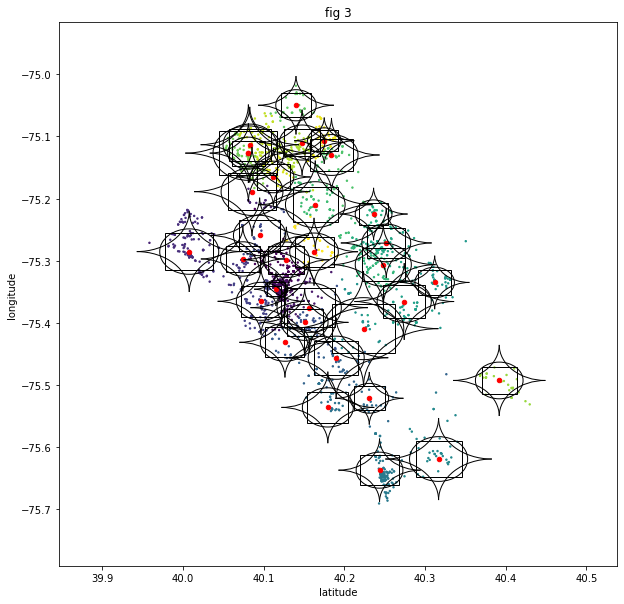

In [20]:
fig, ax = plt.subplots()

ax.scatter(D[:,0], D[:,1], c=D[:,4], s=2)
ax.scatter(station_locations[:,1], station_locations[:,2], s=20, c='red')

for i, station in enumerate(station_avg_distances):
    addHyperbolic(ax, station_locations[i,1], station_locations[i,2], station[0])
    addEuclidian(ax, station_locations[i,1], station_locations[i,2], station[1])
    addManhattan(ax, station_locations[i,1], station_locations[i,2], station[2])

fig.set_figheight(10)
fig.set_figwidth(10)
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("fig 3")
plt.show()

In [22]:
D_no_target_data = D[:,0:2]

def np_kmeans(d, k, eps, p, maxiter=200):
    t = 0
    mean = np.mean(d, axis=0)
    std = np.std(d, axis=0)
    original_reps = np.random.rand(k,d.shape[1])*std+mean
    reps = original_reps
    while True:
        t += 1
        #print(f"Iteration #{t}, reps: \n{reps}")
        clusters = [[] for i in range(k)]
        
        #assign each instance to a rep
        for i, row in enumerate(D):
            dists = [pnorm(row[0], row[1], rep[0], rep[1], p) for rep in reps]
            #print(dists)
            c = np.argmin(dists)
            #print(c)
            clusters[c].append(i)
        
        #calculate mean for each rep
        newreps = np.ndarray(reps.shape)
        for i, cluster in enumerate(clusters):
            clustered_items = d[cluster]
            if len(clustered_items)>0:
                mean = np.mean(clustered_items, axis=0)
                newreps[i] = mean
            else:
                newreps[i] = reps[i]
        #print(f"Newreps: \n{newreps}")
        
        #check if less than epsilon
        if (np.linalg.norm(newreps-reps)**2) < eps or t > maxiter:
            return clusters, newreps
        else:
            reps = newreps


            
k = len(station_locations)
eps = .0001

clusters_l2, reps_l2 = np_kmeans(D_no_target_data, k, eps, 2)
clusters_l1, reps_l1 = np_kmeans(D_no_target_data, k, eps, 1)
clusters_lHalf, reps_lHalf = np_kmeans(D_no_target_data, k, eps, .5)


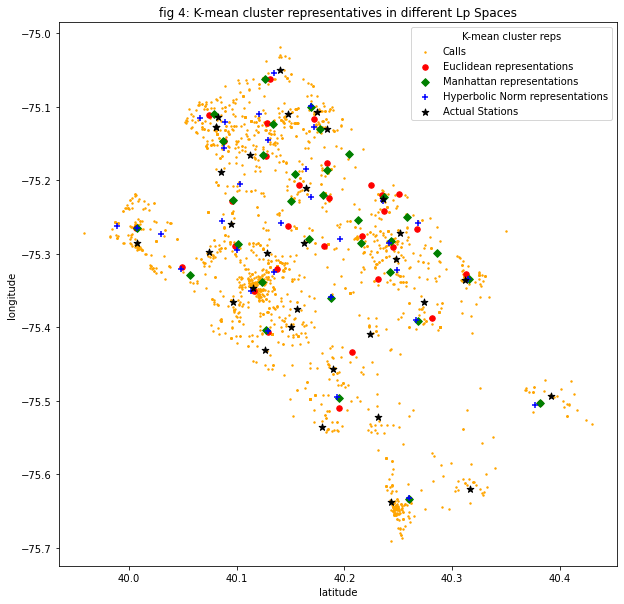

In [33]:

fig, ax = plt.subplots()
ax.scatter(D_no_target_data[:,0], D_no_target_data[:,1], s=2, c='orange', label='Calls')
ax.scatter(reps_l2[:,0], reps_l2[:,1], s=30, c='red', label="Euclidean representations")
ax.scatter(reps_l1[:,0], reps_l1[:,1], s=30, c='green', marker='D', label='Manhattan representations')
ax.scatter(reps_lHalf[:,0], reps_lHalf[:,1], s=30, c='blue', marker='+', label='Hyperbolic Norm representations')
ax.scatter(station_locations[:,1], station_locations[:,2],marker='*', s=50, c='black', label="Actual Stations")

plt.xlabel("latitude")
plt.ylabel("longitude")
plt.legend(title='K-mean cluster reps')
plt.title("fig 4: K-mean cluster representatives in different Lp Spaces")

fig.set_figheight(10)
fig.set_figwidth(10)

In [12]:
#contingency table

def contingencyTable(true_clusters, pred_clusters):
    table = np.ndarray((len(pred_clusters), len(true_clusters)))
    
    for iy, ix in np.ndindex(table.shape):
        intersection = len([value for value in pred_clusters[ix] if value in true_clusters[iy]])
        table[ix, iy] = intersection
    return table

def precision(table, index):
    numerator = max(table[index])
    denominator = sum(table[index])
    return numerator/denominator

def recall(table, index):
 
    maxval = max(table[index])
    Ji = np.where(table[index]==maxval)[0][0] #which index has a bigger value across row i?
    
    numerator = (table[index,Ji])
    denominator = (sum(table[:,Ji]))
    return (numerator/denominator)

def fScore(table):
    scores = []
    for i in range(len(table)):
        numerator = 2 * precision(table, i) * recall(table, i)
        denominator = precision(table, i) + recall(table, i)
        scores.append(numerator/denominator)
    return(sum(scores)/len(scores))


TT_l2 = contingencyTable(clusters_truth,clusters_l2)
TT_l1 = contingencyTable(clusters_truth,clusters_l1)
TT_lHalf = contingencyTable(clusters_truth,clusters_lHalf)

print(fScore(TT_l2))
print(fScore(TT_l1))
print(fScore(TT_lHalf))

0.5944001308037231
0.5637722747044326
0.5921620579331954
